# CHAPTER 2: K-Means Clustering

Objective: Bin your data into groups where there aren't existing labels to try to predict

In this chapter, we will be trying to group together customers based on purchase behavior in the hopes we could try to market to each group separately and with custom copy compared to just sending the same ad copy to every single customer

In [229]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
excel_file_obj = pd.ExcelFile("../raw_data/WineKMC.xlsx")
# Information on the type of offers
offers = pd.read_excel(excel_file_obj, "OfferInformation")
# Information on which customers took which offers
transactions = pd.read_excel(excel_file_obj, "Transactions")

In [3]:
offers.head()

,Offer #,Campaign,Varietal,Minimum Qty (kg),Discount (%),Origin,Past Peak
0,1,January,Malbec,72,56,France,False
1,2,January,Pinot Noir,72,17,France,False
2,3,February,Espumante,144,32,Oregon,True
3,4,February,Champagne,72,48,France,True
4,5,February,Cabernet Sauvignon,144,44,New Zealand,True


In [4]:
transactions.head()

,Customer Last Name,Offer #
0,Smith,2
1,Smith,24
2,Johnson,17
3,Johnson,24
4,Johnson,26


### In the book, he creates a matrix where rows are offers and columns are customers, this would create clusters by offer , where the cluster would live in 100 dimensional space. We want to instead cluster the customers in 32-dimensional space, so will change format since sklearn kMeans expects a dataframe where the objects you are trying to cluster live as rows

In [184]:
customer_order_matrix = pd.pivot_table(transactions, 
                                       index=["Customer Last Name"],
                                       columns=["Offer #"],
                                       aggfunc=lambda x: int(np.size(x) > 0),
                                       fill_value=0
                                      )

In [185]:
customer_order_matrix.head()

Offer #,1,2,3,4,5,6,7,8,9,10,...,23,24,25,26,27,28,29,30,31,32
Customer Last Name,,,,,,,,,,,,,,,,,,,,,
Adams,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
Allen,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
Anderson,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
Bailey,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
Baker,0,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,1,0


## K-means.
     Found this article really good for refreshing on why centroid locations are set where they are:
     https://www.cs.princeton.edu/courses/archive/fall18/cos324/files/kmeans.pdf
     Slide 30 from here is also good:
     https://github.com/harvard-ml-courses/cs181-lectures/blob/master/s17/12.handout.pdf
     
     This also helped me understand why the algorithm converges (cost goes down over time):
     https://cseweb.ucsd.edu/~dasgupta/291-unsup/lec2.pdf
     
     
     But here is lloyd's algo in a nutshell:
     1. Initliaize K where K is the number of clusters
     1. Pick K random vectors u_k in space
     2. Assign each point in your data to closest u_k using Euclidian Distance (will have to standarize feature set if necessary)
     3. For each cluster, set new u_k to be the centroid or avg of all the points in the cluster.
     
     NOTE: This algo is non-deterministic so can get different runs if you run over and over

In [225]:
from sklearn.cluster import KMeans
# Follow the book with K = 4

kmeans = KMeans(n_clusters=4, random_state=3).fit(customer_order_matrix)
cluster_assignments = kmeans.labels_
print("Total Distance", kmeans.inertia_)

Total Distance 214.5642227905655


### So my cluster centers live 32 dimensional space, one for each product and there are 100 cluster assignments, one for each customer

In [191]:
cluster_assignments = kmeans.labels_

In [202]:
customer_list = customer_order_matrix.index

In [224]:
customer_cluster = list(zip(customer_list, cluster_assignments))
customer_cluster[0:5]

[('Adams', 0), ('Allen', 3), ('Anderson', 1), ('Bailey', 0), ('Baker', 0)]

In [205]:
customer_order_matrix.head()

Offer #,1,2,3,4,5,6,7,8,9,10,...,23,24,25,26,27,28,29,30,31,32
Customer Last Name,,,,,,,,,,,,,,,,,,,,,
Adams,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
Allen,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
Anderson,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
Bailey,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
Baker,0,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,1,0


In [208]:
# Want to transpose it so easier to get sums when orders are the row
orders_T = customer_order_matrix.T

In [227]:
def get_customers_from_cluster(cluster_number, customer_cluster_list, df):
    customers_to_keep = [customer for (customer, cluster) 
                            in customer_cluster_list if cluster == cluster_number]
    offer_sums = df.loc[:, customers_to_keep]
    offer_sums.loc[:, "total_orders"] = df.loc[:, customers_to_keep].sum(axis=1)
    offer_sums = offer_sums.drop(customers_to_keep, axis=1)
    return offer_sums

In [228]:
for i in range(4):
    print("Cluster", i)
    cluster_df = get_customers_from_cluster(i, customer_cluster, orders_T)
    print("Num Products Ordered in Cluster:", np.sum(cluster_df["total_orders"] > 0))
    print(cluster_df.sort_values("total_orders", ascending=False).head(8))
    print("\n")

Cluster 0
Num Products Ordered in Cluster: 16
Customer Last Name  total_orders
Offer #                         
30                            17
7                             16
8                             16
29                            16
18                            13
13                             6
10                             3
11                             1


Cluster 1
Num Products Ordered in Cluster: 10
Customer Last Name  total_orders
Offer #                         
26                            12
24                            12
17                             7
2                              7
1                              2
10                             1
12                             1
27                             1


Cluster 2
Num Products Ordered in Cluster: 27
Customer Last Name  total_orders
Offer #                         
22                            21
31                             8
6                              7
14                             7


### Conclusion is you can see that it did successfully try to find certain ordering patterns and group customers accordingly

## Next going to pick k

In [258]:
k_vector = range(2, 10)

## Method 1 not in book - just use inertia or Sum of squared distances of samples to their closest cluster center and look for kink


In [259]:
distance_vals = []
for k in k_vector:
    km = KMeans(n_clusters=k, random_state=3).fit(customer_order_matrix)
    distance_vals.append(km.inertia_)

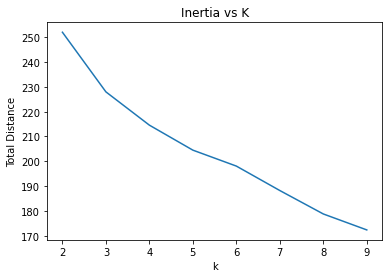

In [260]:
plt.plot(k_vector, distance_vals)
plt.xlabel("k")
plt.ylabel("Total Distance")
plt.title("Inertia vs K")
plt.show()

### This displays the down side of this metric, you may not always see a "kink" in this case you would probably go with 3 and 5 otherwise number of clusters becomes too high to be useful from a business perspective

### Method 2 - Silhouette Score

(Avg Distance to those in nearest neighboring cluster - Avg Dist to those in my cluster) / Maximum of those 2

The denominator keeps it between -1 and 1. If the two values in the numerator are almost the same then that means the value will be 0, which makes sense, if a point is just as close to another cluster as it's own, then it's not a very good segmentation. If it's less than negative 1 that is a very bad score because it means a point in cluster a was actually closer to points in cluster b and should have been moved

In [261]:
from sklearn.metrics import silhouette_score
silhouette_scores = []
for k in k_vector:
    km = KMeans(n_clusters=k, random_state=3)
    preds = km.fit_predict(customer_order_matrix)
    score = silhouette_score(customer_order_matrix, preds)
    silhouette_scores.append(score)

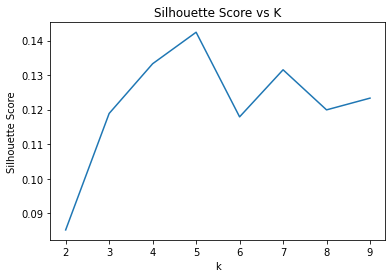

In [262]:
plt.plot(k_vector, silhouette_scores)
plt.xlabel("k")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score vs K")
plt.show()

### Take-away, so all of these values are close to k which isn't the greatest, but this tells you to probably pick k=5 in order to maximize the sillhouette score

### Can also do k-medians (though not sure if the book meant k-mediods) since k-medios is where you actually pick your centroids as data-points. The book says that k-medians guarantees you get one of the data points as a centroid, don't think this is true

### Switching the Distance Metric - Hamming Distance
Basically count the number of mismatches between two binary vectors to get your Hamming distance

### Handling Asymmetry

From a business perspective being similiar on 1's is more important than being similiar on 0s.  If they both ordered the product, we know they both like product, whereas if someone doesn't order it, doesn't mean they don't like, they could just already have it at home etc

See here:
http://tutorial.math.lamar.edu/Classes/CalcII/DotProduct.aspx

to see that

cos theta = (a * b) / ||a|| ||b||

What does that mean in our context

Means Count of Matches Purchases in the Numerator
Denominator - Square root of number of purchases in each category

So this basically allows you to get a sense of how much overlap they have in terms of purchases

Example (1, 0) and (1, 1)

we know cos theta will be 1 / sqrt(2)

Seen anothe rway

a * b = 1 * 1 + 1 * 0 = 1
sqrt(a) = 1
sqrt(b) = sqrt(2)

so equals 1 / sqrt(2)

Keys:
1. numerator allows you to count number of matches purchases only
2. The denmiator allows you to control for factors when you get a vector that is 1 in everythigng, willb e farther away from vectors that match on the same deals
3. cosine distance = 1 - cosine similiarity